# EDA 

**Autor:** AGUSTÍN SILVIO ANDRÉS ROJAS

**Fecha:** 3/9/2025

# Index

1. [Packages](#packages)
2. [Data exploration](#data-exploration)
3. [Plots](#plots)
   
   3.1. [Correlation matrix](#correlation-matrix)

   3.2. [TOP CORRELATIONS BAR CHART](#top-correlations-bar-chart)

   3.3. [FRAUD DISTRIBUTION](#fraud-distribution) 

    3.3.0. [BOXPLOTS BY FRAUD STATUS](#boxplots-by-fraud-status)

    3.3.1. [FRAUD RATE BY CATEGORICAL VARIABLES](#fraud-rate-by-categorical-variables)

    3.3.2. [FRAUD RATE BY BINARY VARIABLES](#fraud-rate-by-binary-variables)

    3.3.3. [TIME-BASED ANALYSIS](#time-based-analysis)

    3.3.4. [DISTRIBUCIONES DE ALGUNAS VARIABLES NÚMERICAS](#distribuciones-de-algunas-variables-númericas)

4. [Outliers](#outliers)
5. [Conclusiones](#conclusiones)
6. [Dashboard](#dashboard) (no terminado)

# Packages

In [ ]:
(
    import sys
    import os
    from pathlib import Path
    sys.path.append(os.path.abspath(".."))

    from mlparadetectarfraudes.data import data
 
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import statsmodels.api as sm
    from scipy.stats import pointbiserialr, chi2_contingency
)

# Data exploration

In [ ]:
data.sort_values(["transaction_datetime"], ascending=False)

,transaction_datetime,amount,user_age,user_income,device_type,os_type,browser,country,city_size,num_products,...,transaction_month,is_night,is_weekend,amount_to_income_ratio,avg_product_price,high_value_transaction,new_customer,unusual_device_combo,is_fraud,user_id
48372,2023-12-30,1084.95,62,114577,tablet,iOS,Chrome,ARS,Suburban,2,...,12,1,1,0.113630,542.475000,1,0,0,0,48373
47241,2023-12-30,3144.30,42,91686,mobile,Android,Firefox,BR,Metro,1,...,12,1,1,0.411531,3144.300000,1,0,0,0,47242
8781,2023-12-30,939.75,59,90966,mobile,iOS,Chrome,US,Metro,3,...,12,1,1,0.123969,313.250000,0,0,0,0,8782
37436,2023-12-30,714.03,18,104386,desktop,Android,Chrome,BR,Metro,2,...,12,1,1,0.082083,357.015000,0,0,0,0,37437
5880,2023-12-30,620.41,74,103092,desktop,Windows,Safari,UK,Metro,3,...,12,1,1,0.072216,206.803333,0,0,0,0,5881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44246,2023-01-01,5396.78,35,79723,mobile,Windows,Edge,US,Suburban,2,...,1,1,1,0.812330,2698.390000,1,0,1,1,44247
23071,2023-01-01,721.59,51,66936,mobile,Android,Firefox,MX,Metro,4,...,1,1,1,0.129364,180.397500,0,0,0,1,23072
37578,2023-01-01,95.95,18,94644,mobile,Windows,Safari,UK,Urban,2,...,1,1,1,0.012166,47.975000,0,0,1,1,37579
8476,2023-01-01,934.81,31,82431,mobile,MacOS,Firefox,UK,Urban,2,...,1,1,1,0.136086,467.405000,0,0,0,1,8477


In [11]:

#Verifiquemos si tenemos como estructura de dato un dataframe!
print("Información sobre el set de datos: ",type(data))
#Conocer informacion basica
print('Cantidad de Filas y columnas:',data.shape)
print('Nombre columnas:',data.columns)



Información sobre el set de datos:  <class 'pandas.core.frame.DataFrame'>
Cantidad de Filas y columnas: (50000, 26)
Nombre columnas: Index(['transaction_datetime', 'amount', 'user_age', 'user_income',
       'device_type', 'os_type', 'browser', 'country', 'city_size',
       'num_products', 'repeat_customer', 'account_age_days',
       'previous_chargebacks', 'is_dead_user', 'transaction_hour',
       'transaction_day', 'transaction_month', 'is_night', 'is_weekend',
       'amount_to_income_ratio', 'avg_product_price', 'high_value_transaction',
       'new_customer', 'unusual_device_combo', 'is_fraud', 'user_id'],
      dtype='object')


In [ ]:
#Tipos de datos
data.dtypes

transaction_datetime      datetime64[ns]
amount                           float64
user_age                           int32
user_income                        int64
device_type                       object
os_type                           object
browser                           object
country                           object
city_size                         object
num_products                       int32
repeat_customer                    int64
account_age_days                   int32
previous_chargebacks               int32
is_dead_user                       int64
transaction_hour                   int32
transaction_day                    int32
transaction_month                  int32
is_night                           int64
is_weekend                         int64
amount_to_income_ratio           float64
avg_product_price                float64
high_value_transaction             int64
new_customer                       int64
unusual_device_combo               int64
is_fraud        

In [25]:
# cantidad de unicos
print('Cantidad de valores unicos por columna:\n',data.nunique().sort_values())

Cantidad de valores unicos por columna:
 is_night                      1
new_customer                  1
transaction_hour              1
high_value_transaction        2
unusual_device_combo          2
is_dead_user                  2
is_fraud                      2
repeat_customer               2
is_weekend                    2
device_type                   3
previous_chargebacks          4
browser                       4
os_type                       4
city_size                     4
country                       5
transaction_day               7
transaction_month            12
num_products                 12
user_age                     57
account_age_days            150
transaction_datetime        364
user_income               33038
amount                    42775
avg_product_price         46241
amount_to_income_ratio    50000
user_id                   50000
dtype: int64


In [24]:
# Mostrar solo columnas con valores nulos
null_counts = data.isnull().sum()
null_columns = null_counts[null_counts > 0]

if not null_columns.empty:
    print("Columnas con valores nulos:")
    print(null_columns)
else:
    print("No hay valores nulos en el DataFrame.")



No hay valores nulos en el DataFrame.


In [38]:
# SEPARATE VARIABLE TYPES


numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

    # Detectar columnas binarias
binary_cols = [col for col in numeric_cols 
                if col != 'is_fraud' 
                and data[col].nunique() <= 2 
                and all(val in [0, 1, True, False] for val in data[col].dropna().unique())]

    # Actualizar numeric_cols excluyendo las binarias y transaction_datetime
numeric_cols = [col for col in numeric_cols if col not in binary_cols and col != 'transaction_datetime' and col !='user_id' and col !='is_fraud']


print("Numerical columns:")
print(numeric_cols)
print("Categorical columns:")
print(categorical_cols)
print("Binary columns:")
print(binary_cols)

Numerical columns:
['amount', 'user_age', 'user_income', 'num_products', 'account_age_days', 'previous_chargebacks', 'transaction_day', 'transaction_month', 'amount_to_income_ratio', 'avg_product_price']
Categorical columns:
['device_type', 'os_type', 'browser', 'country', 'city_size']
Binary columns:
['repeat_customer', 'is_dead_user', 'transaction_hour', 'is_night', 'is_weekend', 'high_value_transaction', 'new_customer', 'unusual_device_combo']


In [21]:
print('Estadísticas básicas de la variables numéricas')
print(data[numeric_cols].describe().round(2).T)

Estadísticas básicas de la variables numéricas
                          count      mean       std       min       25%  \
amount                  50000.0   2013.58   4766.07      0.02    186.08   
user_age                50000.0     45.82     16.45     18.00     32.00   
user_income             50000.0  90038.16  14998.38  30010.00  79960.00   
num_products            50000.0      3.00      1.41      1.00      2.00   
account_age_days        50000.0    365.00     19.08    272.00    352.00   
previous_chargebacks    50000.0      0.10      0.31      0.00      0.00   
transaction_day         50000.0      3.01      2.00      0.00      1.00   
transaction_month       50000.0      6.48      3.45      1.00      3.00   
amount_to_income_ratio  50000.0      0.28      0.67      0.00      0.02   
avg_product_price       50000.0    861.26   2362.71      0.00     63.95   

                             50%        75%        max  
amount                    473.05    1185.06   71345.37  
user_age     

In [22]:
# El promedio de las variables binarias es la proporción que representan
binary_props = data[binary_cols].mean() * 100
for col, prop in binary_props.items():
    print(f"Proporción de la variable '{col}': {prop:.2f}%")

Proporción de la variable 'repeat_customer': 70.16%
Proporción de la variable 'is_dead_user': 0.02%
Proporción de la variable 'transaction_hour': 0.00%
Proporción de la variable 'is_night': 100.00%
Proporción de la variable 'is_weekend': 28.88%
Proporción de la variable 'high_value_transaction': 28.72%
Proporción de la variable 'new_customer': 0.00%
Proporción de la variable 'unusual_device_combo': 15.05%


In [88]:
# Sumar todos los valores de la columna 'is_fraud'
suma_total_fraudes = data['is_fraud'].sum()
# Agrupar por país y sumar el número de fraudes en cada pais
fraude_x_pais = data.groupby(['country']).agg({'is_fraud': 'sum'}).reset_index()
# Utiliza el método rename para cambiar el nombre de la columna
#data.rename(columns={'user_age': 'user_age'}, inplace=True)


In [51]:
# Analisis de montos y fraudes
total_amount = data['amount'].sum()
total_fraude_amount = data.loc[data['is_fraud'] == 1, 'amount'].sum()
print(f"Monto total de transacciones: ${total_amount:,.2f}")
print(f"Monto total perdido por fraudes: ${total_fraude_amount:,.2f}")
print(f"Porcentaje perdido del total de transacciones: {total_fraude_amount / total_amount * 100:.2f}%")
print(f"Que porcentaje representas el monto perdido por fraude respecto de al monto de transacciones legítimas: {total_fraude_amount / data[data['is_fraud'] == 0]['amount'].sum() * 100:.2f}%")


Monto total de transacciones: $100,678,883.85
Monto total perdido por fraudes: $41,796,570.12
Porcentaje perdido del total de transacciones: 41.51%
Que porcentaje representas el monto perdido por fraude respecto de al monto de transacciones legítimas: 70.98%


# Plots

In [28]:
# Create directory if it doesn't exist
figures_path = Path('../reports/figures/')
figures_path.mkdir(parents=True, exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

## Correlation matrix

c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\scipy\stats\_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


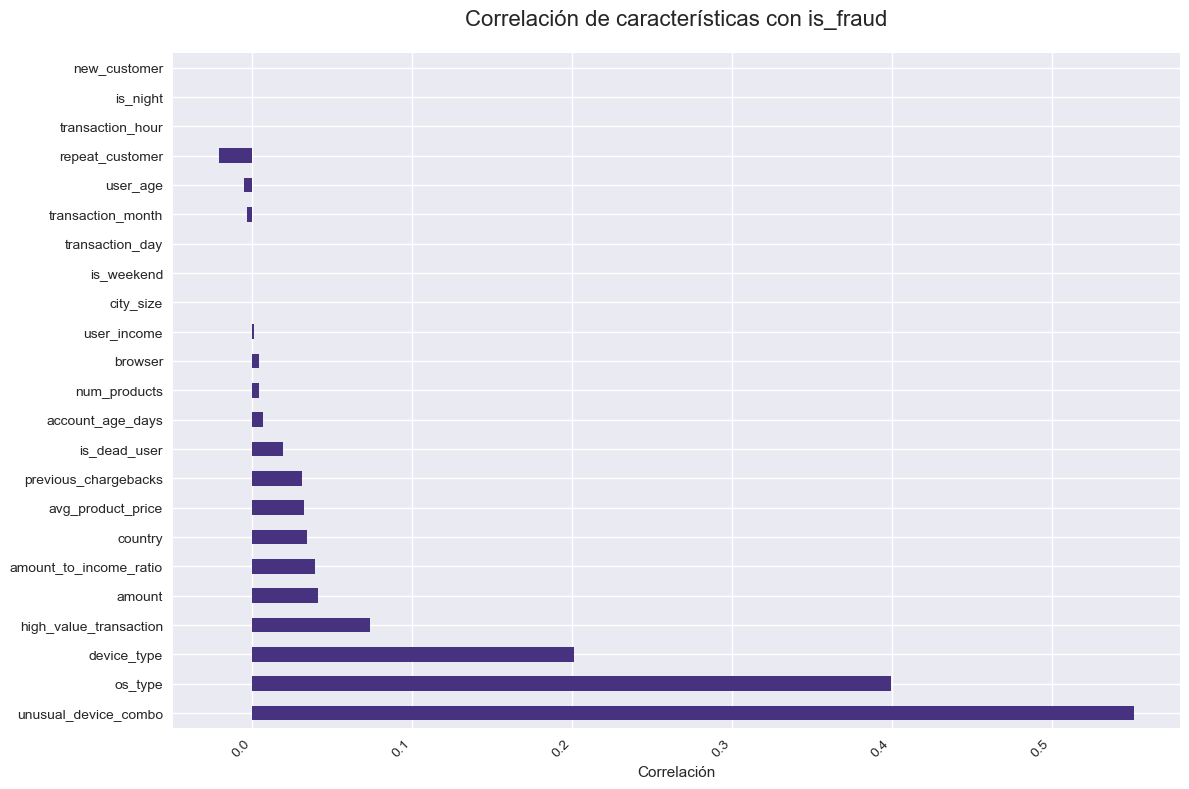

In [31]:
# Cargar tus datos (ya los tienes generados)
df = data.copy().drop('user_id', axis=1)

figures_path = Path('../reports/figures/')
figures_path.mkdir(parents=True, exist_ok=True)


from mlparadetectarfraudes.visualization import calculate_correlations

# Calcular y visualizar correlaciones
correlations = calculate_correlations(df)
plt.figure(figsize=(12, 8))
correlations.plot(kind='barh')
plt.title('Correlación de características con is_fraud', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()

## TOP CORRELATIONS BAR CHART

In [32]:
correlations.head(10)

unusual_device_combo      0.551695
os_type                   0.399268
device_type               0.201114
high_value_transaction    0.073685
amount                    0.041411
amount_to_income_ratio    0.039448
country                   0.034514
avg_product_price         0.032318
previous_chargebacks      0.031079
is_dead_user              0.019445
dtype: float64

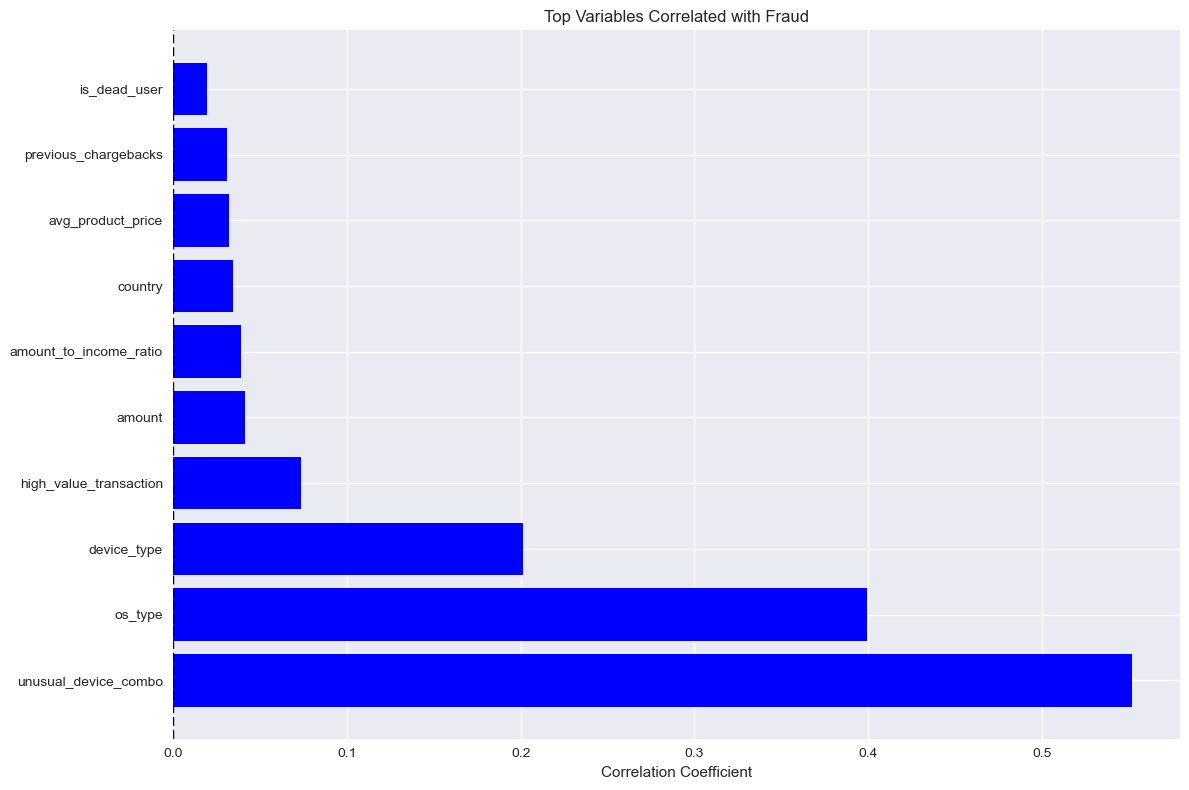

In [33]:
#. TOP CORRELATIONS BAR CHART
plt.figure(figsize=(12, 8))
top_vars = correlations.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_vars.values]

plt.barh(top_vars.index, top_vars.values, color=colors)
plt.xlabel('Correlation Coefficient')
plt.title('Top Variables Correlated with Fraud')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig(figures_path / 'top_correlations.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'top_correlations.pdf', bbox_inches='tight')
plt.show()

## FRAUD DISTRIBUTION

Distribución de fraudes:
is_fraud
0    31606
1    18394
Name: count, dtype: int64
Porcentaje de fraudes: 36.79%


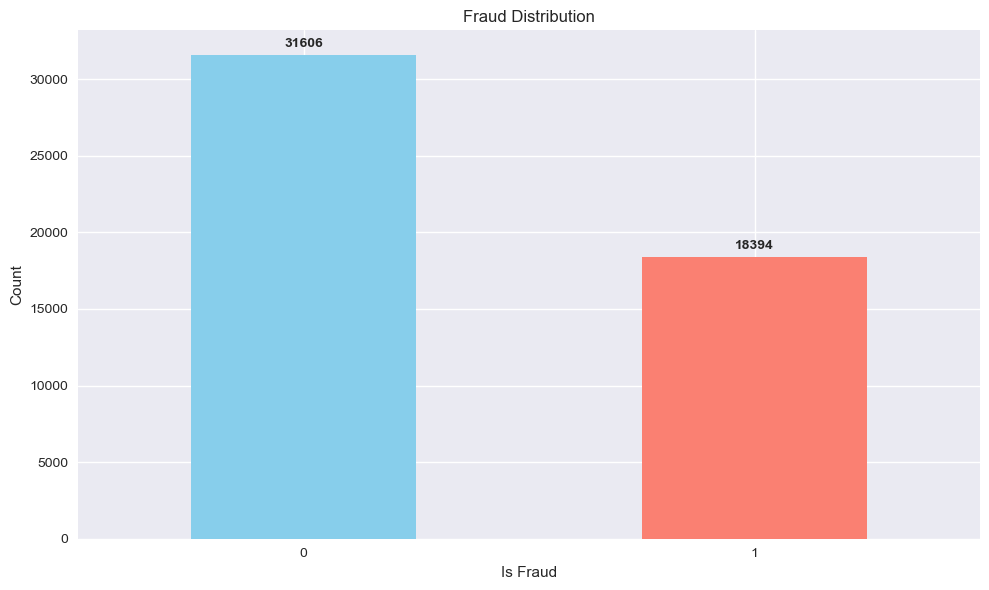

In [34]:
# Ver distribución de la variable objetivo
print("Distribución de fraudes:")
print(df['is_fraud'].value_counts())
print(f"Porcentaje de fraudes: {df['is_fraud'].mean()*100:.2f}%")

#. FRAUD DISTRIBUTION
plt.figure(figsize=(10, 6))
ax = data['is_fraud'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Fraud Distribution')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks(rotation=0)
# Annotate each bar with its value
for i, v in enumerate(data['is_fraud'].value_counts()):
    ax.text(i, v + max(data['is_fraud'].value_counts()) * 0.01, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig(figures_path / 'fraud_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_distribution.pdf', bbox_inches='tight')
plt.show()

### BOXPLOTS BY FRAUD STATUS

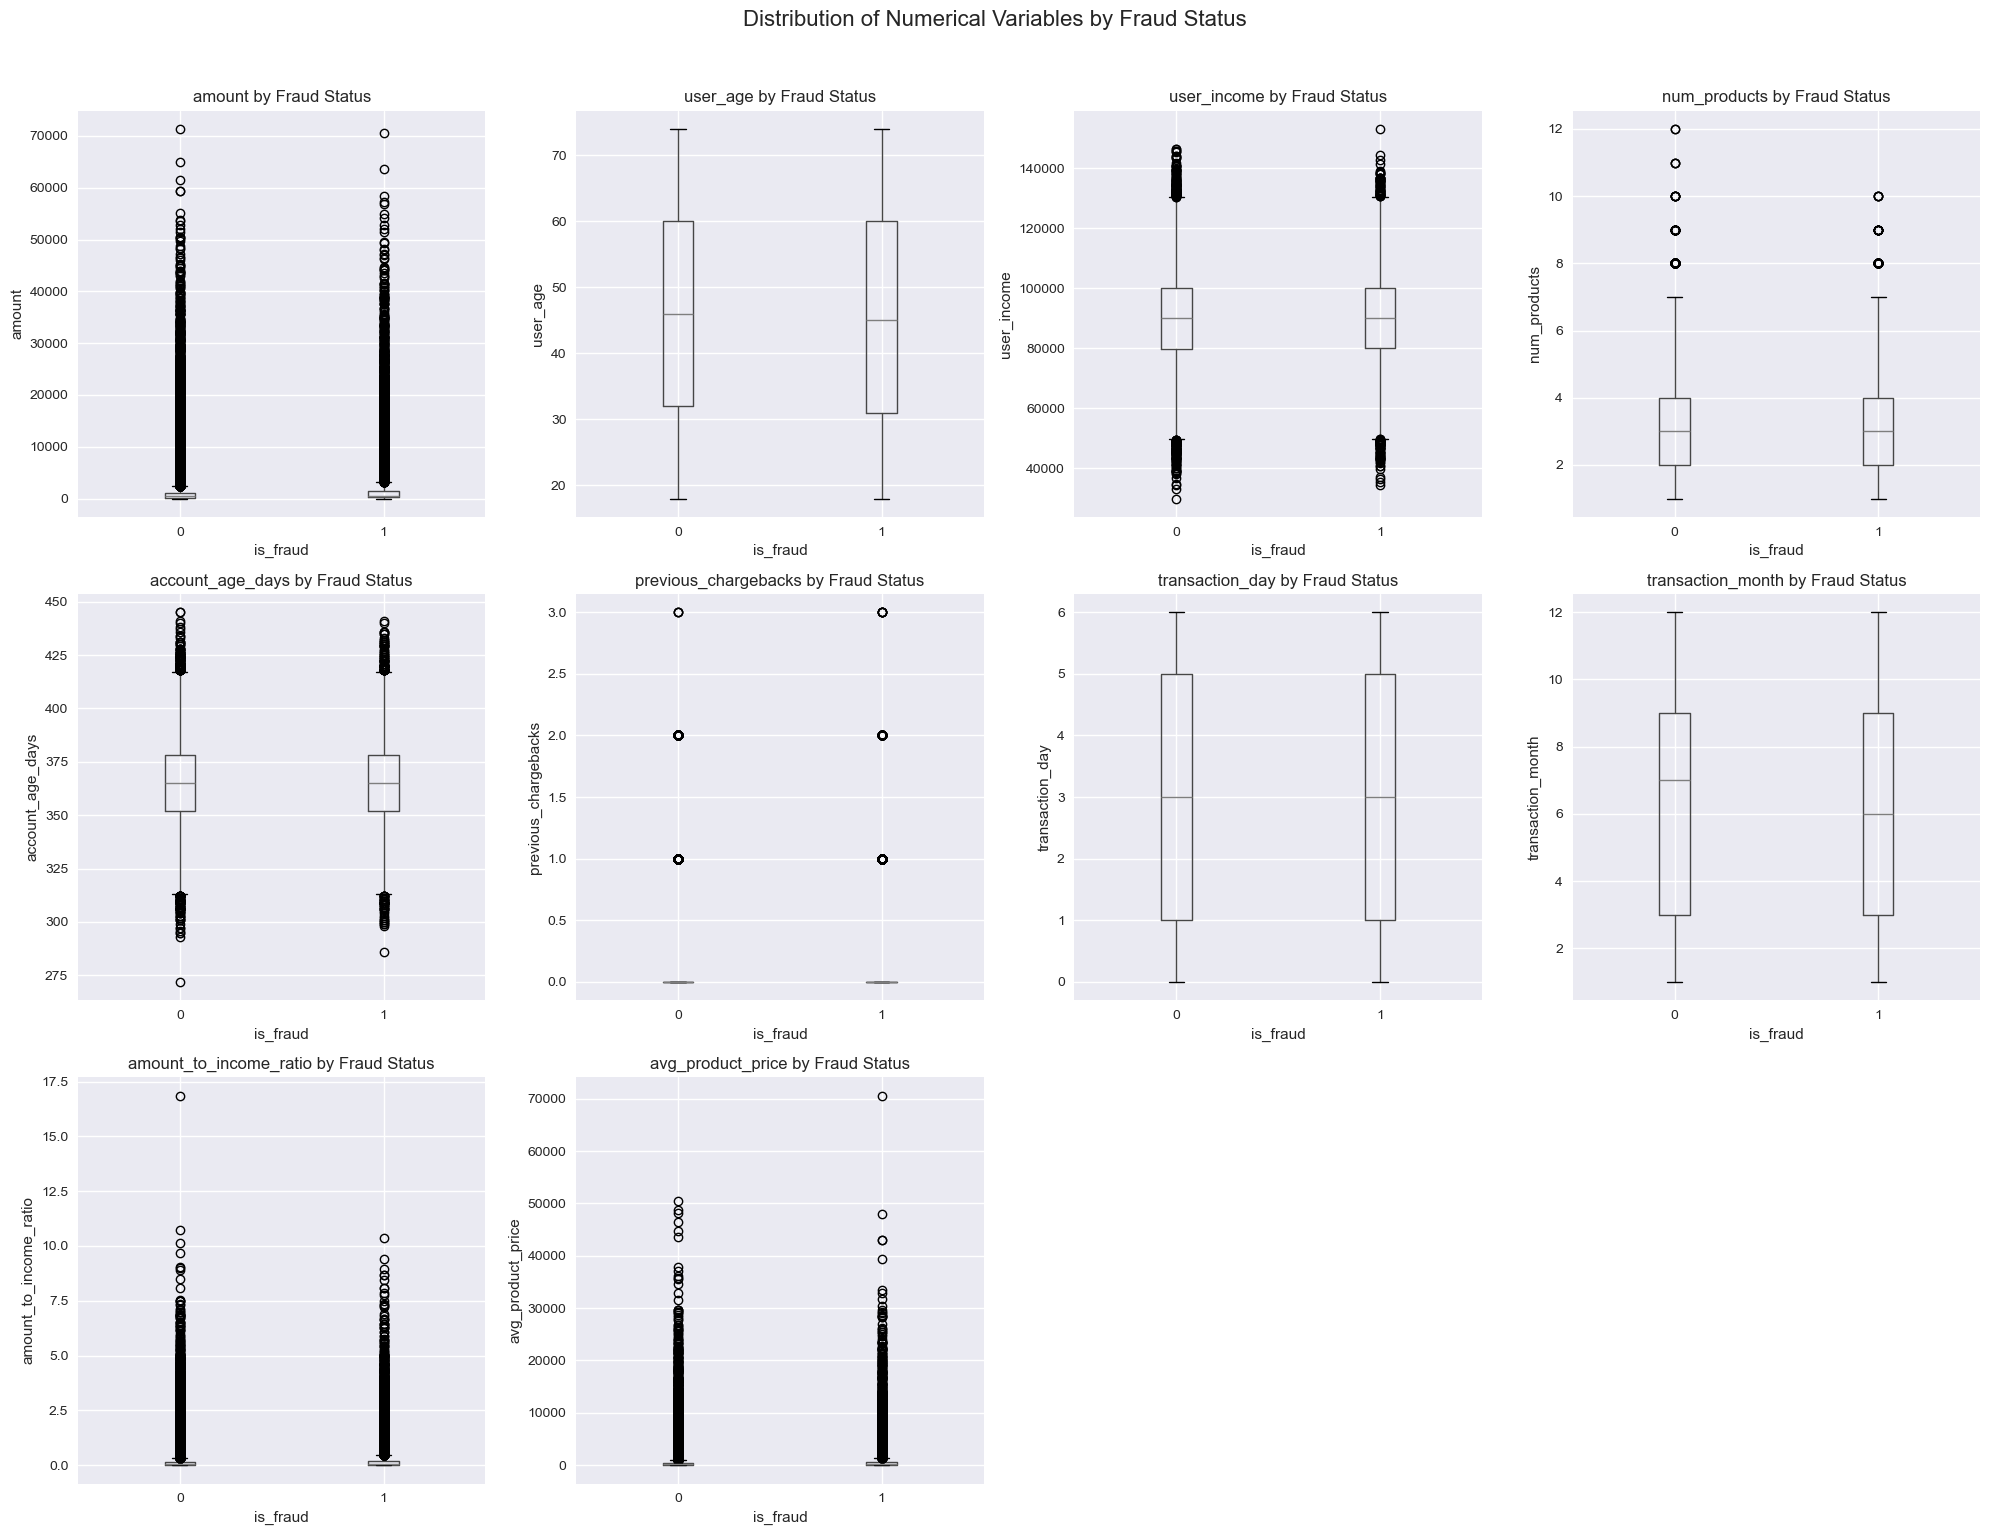

In [35]:
#. BOXPLOTS BY FRAUD STATUS
true_numeric = [col for col in numeric_cols if col not in binary_cols + ['is_fraud']]
n_cols = 4
n_rows = (len(true_numeric) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(true_numeric):
    data.boxplot(column=col, by='is_fraud', ax=axes[i])
    axes[i].set_title(f'{col} by Fraud Status')
    axes[i].set_ylabel(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Numerical Variables by Fraud Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(figures_path / 'boxplots_by_fraud.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'boxplots_by_fraud.pdf', bbox_inches='tight')
plt.show()

Los box plots entre si es fraude o no de las variables númericas no indican diferencias claras.

Los montos de transacciones (amount) se concentran en montos bajos, siendo outliers incluso montos arriba de 1000. 
Tener previous_chargebacks  es atíco.
Tener más de 8 productos (num_product) es atíco.


### FRAUD RATE BY CATEGORICAL VARIABLES

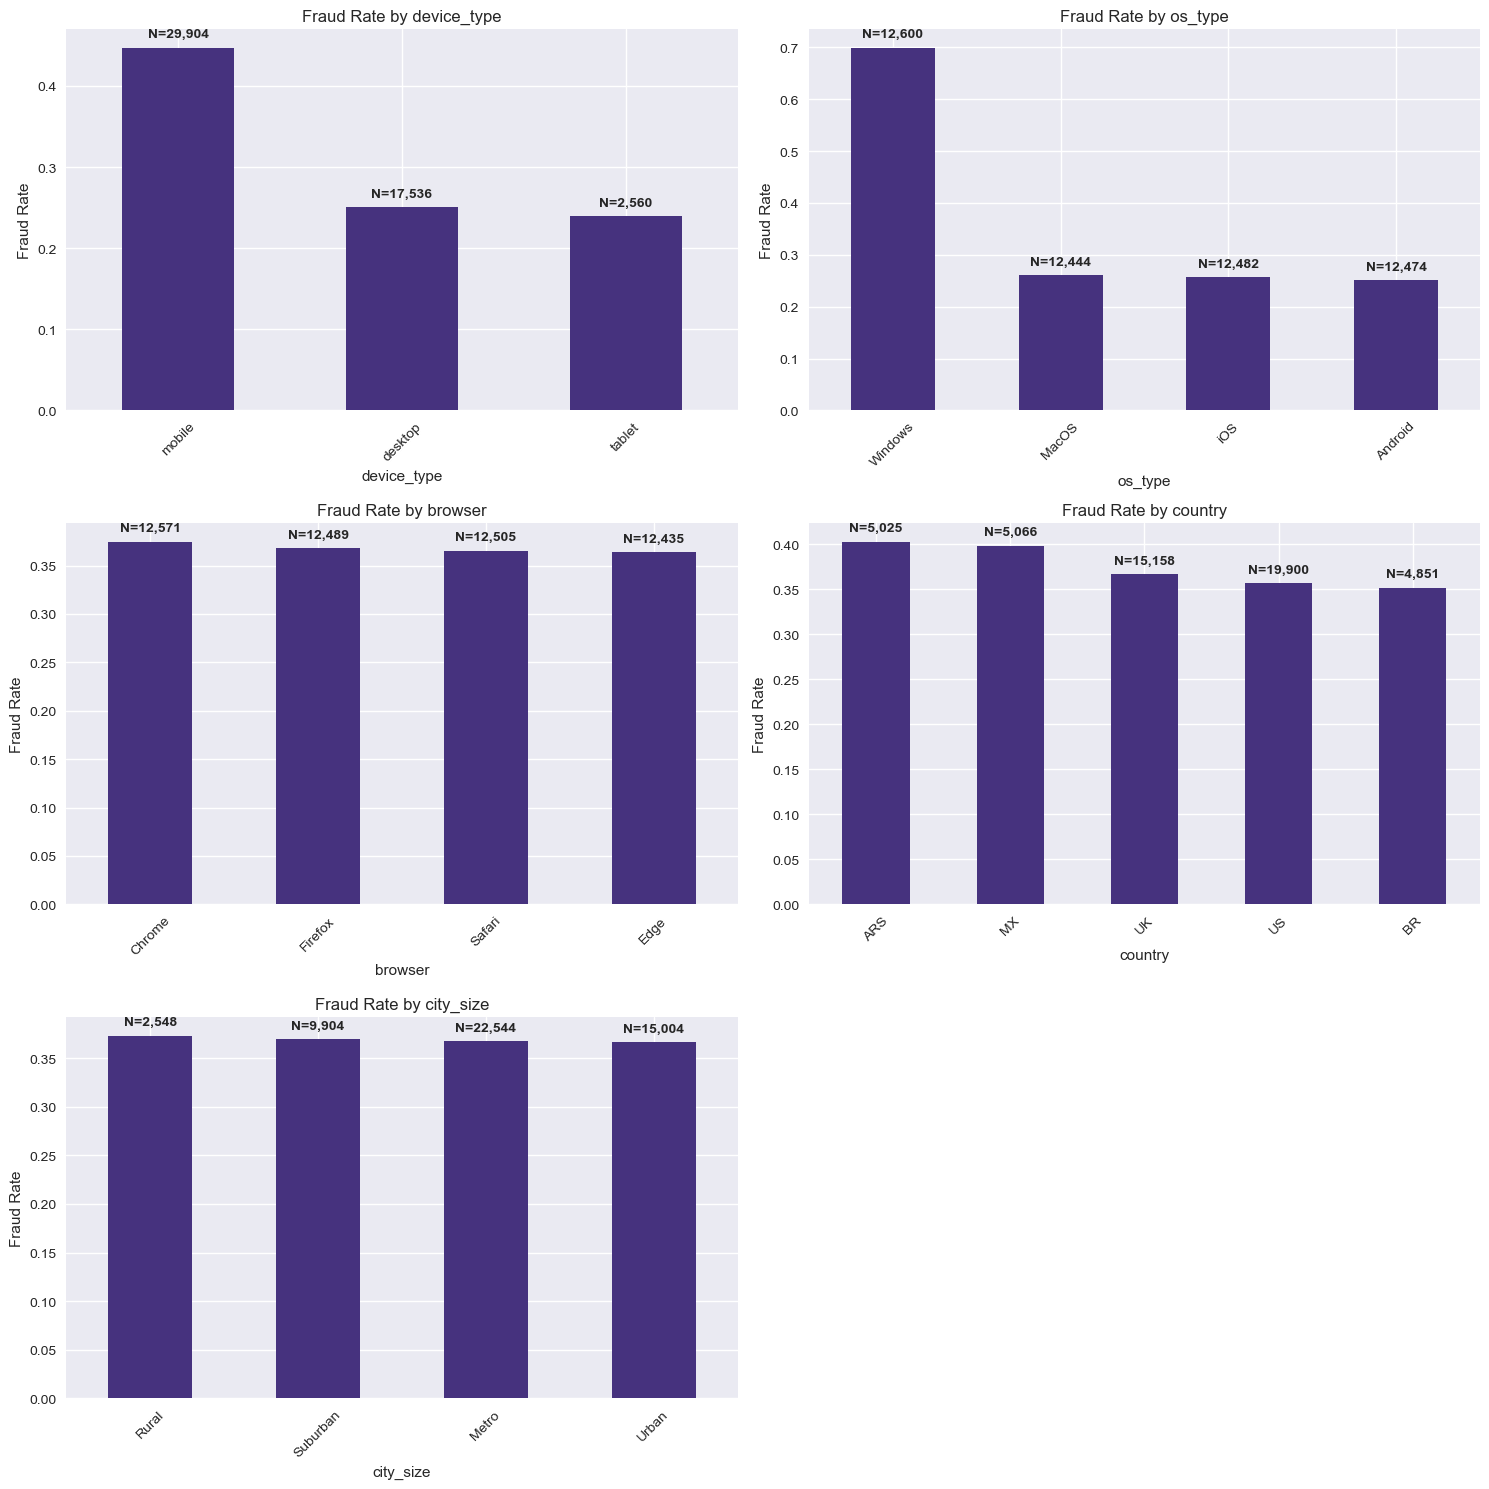

In [ ]:
#. FRAUD RATE BY CATEGORICAL VARIABLES (before run the separate variables cell in data exploration section)

n_cats = len(categorical_cols)
n_cols = 2
n_rows = (n_cats + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    fraud_rates = data.groupby(col)['is_fraud'].mean().sort_values(ascending=False).head(8)
    counts = data[col].value_counts()
    ax = fraud_rates.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Fraud Rate by {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Fraud Rate')
    # Add count labels above bars with thousands separator
    ymax = fraud_rates.max()
    for idx, value in enumerate(fraud_rates.index):
        axes[i].text(
            idx,
            fraud_rates[value] + ymax * 0.02,  # 2% above the highest bar
            f'N={counts[value]:,}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(figures_path / 'fraud_rate_categorical.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_rate_categorical.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Analisis de fraude de os_type = Windows
print("Analisis de fraude de os_type = Windows")
print(f"Probabilidad de fraude por os_type = Windows: {(data[(data['os_type'] == 'Windows') & (data['is_fraud'] == 1)].shape[0] / data[data['os_type'] == 'Windows'].shape[0] )}")
print(f"Dinero perdido por fraude por os_type = Windows ${data[(data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida  por fraude por os_type = Windows respecto al total de transacciones: {(data[(data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida por fraude por os_type = Windows respecto al total de transacciones no fraudulentas: {(data[(data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida de los fraudes por os_type = Window del total de fraudes: {(data[(data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(2)}%")
print(f"Cantidad de fraudes por os_type = Windows: {data[(data['os_type'] == 'Windows') & (data['is_fraud'] == 1)].shape[0]:,}")
print("--------------------")
# Analisis de fraude de device_type = mobile
print("Analisis de fraude de device_type = mobile")
print(f"Probabilidad de fraude por device_type = mobile: {(data[(data['device_type'] == 'mobile') & (data['is_fraud'] == 1)].shape[0] / data[data['device_type'] == 'mobile'].shape[0])}")
print(f"Dinero perdido por fraude por device_type = mobile ${data[(data['device_type'] == 'mobile') & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida  por fraude por device_type = mobile respecto al total de transacciones: {(data[(data['device_type'] == 'mobile') & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida por fraude por device_type = mobile respecto al total de transacciones no fraudulentas: {(data[(data['device_type'] == 'mobile') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida de los fraudes por device_type = mobile del total de fraudes: {(data[(data['device_type'] == 'mobile') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(2)}%")
print(f"Cantidad de fraudes por device_type = mobile: {data[(data['device_type'] == 'mobile') & (data['is_fraud'] == 1)].shape[0]:,}")
print("--------------------")
# Analisis de fraude device_type = mobile y os_type = Windows
print("Analisis de fraude de device_type = mobile y os_type = Windows")
print(f"Probabilidad de fraude por device_type = mobile y os_type = Windows: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)].shape[0] / data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows')].shape[0])}")
print(f"Dinero perdido por fraude por device_type = mobile y os_type = Windows ${data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida  por fraude por device_type = mobile y os_type = Windows respecto al total de transacciones: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida por fraude por device_type = mobile y os_type = Windows respecto al total de transacciones no fraudulentas: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida de los fraudes por device_type = mobile y os_type = Windows del total de fraudes: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(2)}%")
print(f"Cantidad de fraudes por device_type = mobile y os_type = Windows: {data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)].shape[0]:,}")
print("--------------------")


Analisis de fraude de os_type = Windows
Probabilidad de fraude por os_type = Windows: 0.6996031746031746
Dinero perdido por fraude por os_type = Windows $18,097,684.45
Porcentaje de perdida  por fraude por os_type = Windows respecto al total de transacciones: 17.98%
Porcentaje de perdida por fraude por os_type = Windows respecto al total de transacciones no fraudulentas: 30.74%
Porcentaje de perdida de los fraudes por os_type = Window del total de fraudes: 43.3%
Cantidad de fraudes por os_type = Windows: 8,815
--------------------
Analisis de fraude de device_type = mobile
Probabilidad de fraude por device_type = mobile: 0.4473983413590155
Dinero perdido por fraude por device_type = mobile $29,761,021.71
Porcentaje de perdida  por fraude por device_type = mobile respecto al total de transacciones: 29.56%
Porcentaje de perdida por fraude por device_type = mobile respecto al total de transacciones no fraudulentas: 50.54%
Porcentaje de perdida de los fraudes por device_type = mobile del t

In [64]:
# Analisis de fraude device_type = mobile y os_type != Windows
print("Analisis de fraude de device_type = mobile y os_type != Windows")
print(f"Probabilidad de fraude por device_type = mobile y os_type != Windows: {(data[(data['device_type'] == 'mobile') & (data['os_type'] != 'Windows') & (data['is_fraud'] == 1)].shape[0] / data[(data['device_type'] == 'mobile') & (data['os_type'] != 'Windows')].shape[0])}")
print(f"Dinero perdido por fraude por device_type = mobile y os_type != Windows ${data[(data['device_type'] == 'mobile') & (data['os_type'] != 'Windows') & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida  por fraude por device_type = mobile y os_type != Windows respecto al total de transacciones: {(data[(data['device_type'] == 'mobile') & (data['os_type'] != 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida por fraude por device_type = mobile y os_type != Windows respecto al total de transacciones no fraudulentas: {(data[(data['device_type'] == 'mobile') & (data['os_type'] != 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida de los fraudes por device_type = mobile y os_type != Windows del total de fraudes: {(data[(data['device_type'] == 'mobile') & (data['os_type'] != 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(2)}%")
print(f"Cantidad de fraudes por device_type = mobile y os_type != Windows: {data[(data['device_type'] == 'mobile') & (data['os_type'] != 'Windows') & (data['is_fraud'] == 1)].shape[0]:,}")
print("--------------------")


Analisis de fraude de device_type = mobile y os_type != Windows
Probabilidad de fraude por device_type = mobile y os_type != Windows: 0.26161751563896335
Dinero perdido por fraude por device_type = mobile y os_type != Windows $14,833,539.46
Porcentaje de perdida  por fraude por device_type = mobile y os_type != Windows respecto al total de transacciones: 14.73%
Porcentaje de perdida por fraude por device_type = mobile y os_type != Windows respecto al total de transacciones no fraudulentas: 25.19%
Porcentaje de perdida de los fraudes por device_type = mobile y os_type != Windows del total de fraudes: 35.49%
Cantidad de fraudes por device_type = mobile y os_type != Windows: 5,855
--------------------


In [65]:
# Analisis de fraude device_type != mobile y os_type = Windows
print("Analisis de fraude de device_type != mobile y os_type = Windows")
print(f"Probabilidad de fraude por device_type != mobile y os_type = Windows: {(data[(data['device_type'] != 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)].shape[0] / data[(data['device_type'] != 'mobile') & (data['os_type'] == 'Windows')].shape[0])}")
print(f"Dinero perdido por fraude por device_type != mobile y os_type = Windows ${data[(data['device_type'] != 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida  por fraude por device_type != mobile y os_type = Windows respecto al total de transacciones: {(data[(data['device_type'] != 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida por fraude por device_type != mobile y os_type = Windows respecto al total de transacciones no fraudulentas: {(data[(data['device_type'] != 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida de los fraudes por device_type != mobile y os_type = Windows del total de fraudes: {(data[(data['device_type'] != 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(2)}%")
print(f"Cantidad de fraudes por device_type != mobile y os_type = Windows: {data[(data['device_type'] != 'mobile') & (data['os_type'] == 'Windows') & (data['is_fraud'] == 1)].shape[0]:,}")
print("--------------------")

Analisis de fraude de device_type != mobile y os_type = Windows
Probabilidad de fraude por device_type != mobile y os_type = Windows: 0.25433412135539796
Dinero perdido por fraude por device_type != mobile y os_type = Windows $3,170,202.2
Porcentaje de perdida  por fraude por device_type != mobile y os_type = Windows respecto al total de transacciones: 3.15%
Porcentaje de perdida por fraude por device_type != mobile y os_type = Windows respecto al total de transacciones no fraudulentas: 5.38%
Porcentaje de perdida de los fraudes por device_type != mobile y os_type = Windows del total de fraudes: 7.58%
Cantidad de fraudes por device_type != mobile y os_type = Windows: 1,291
--------------------


### FRAUD RATE BY BINARY COLUMNS

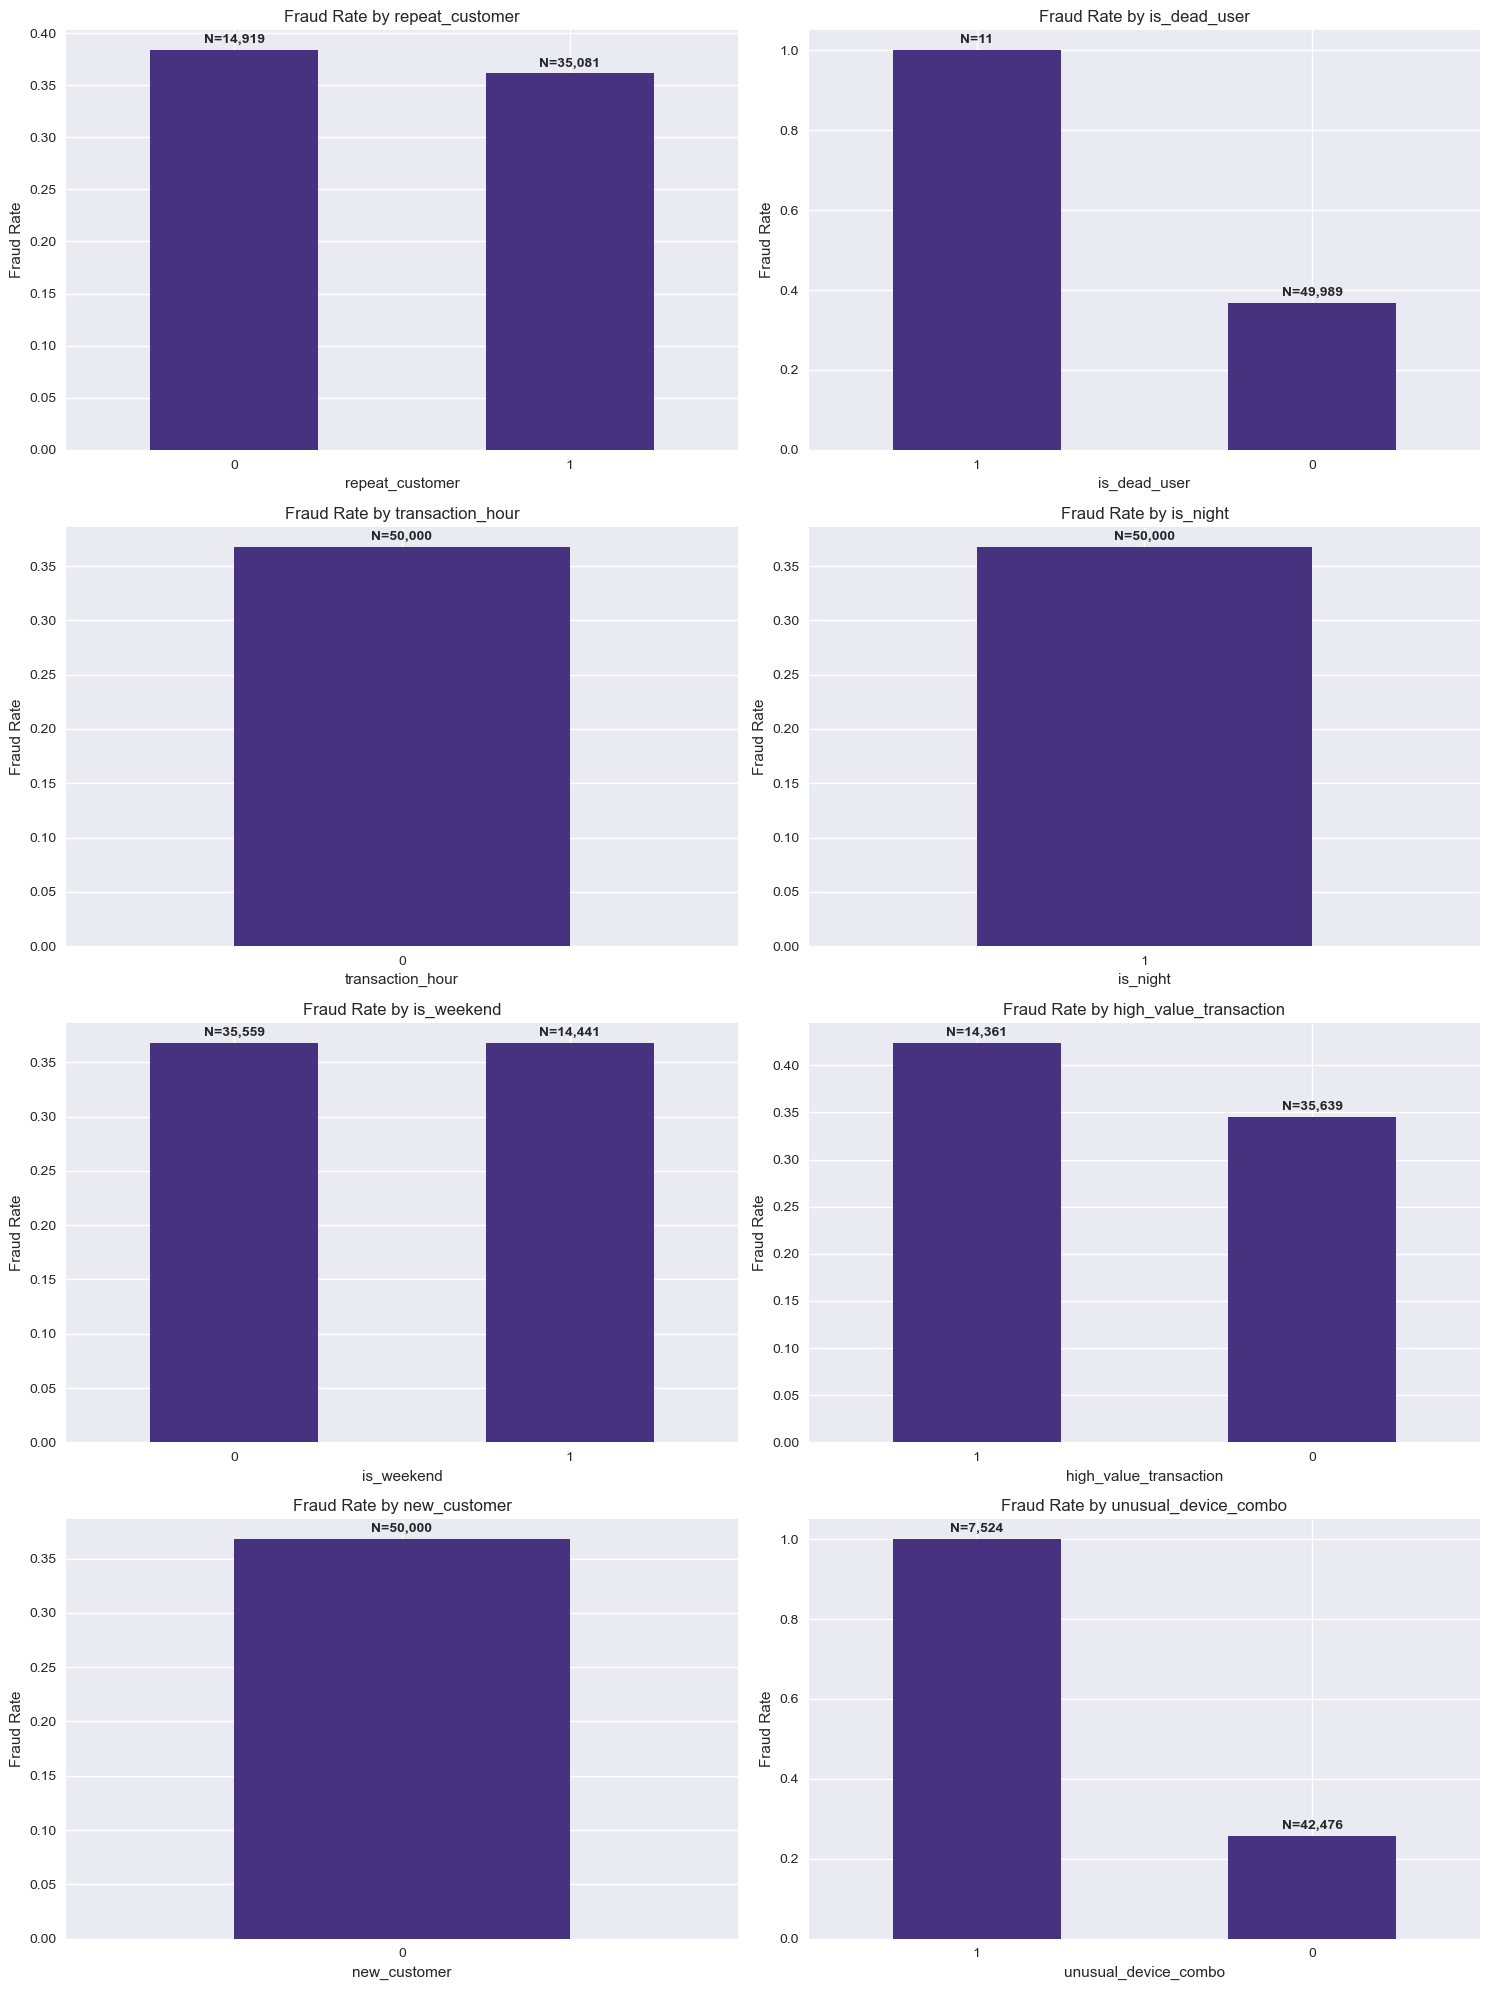

In [39]:
#. FRAUD RATE BY BINARY VARIABLES (before run the separate variables cell in data exploration section)

n_cats = len(binary_cols)
n_cols = 2
n_rows = (n_cats + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(binary_cols):
    fraud_rates = data.groupby(col)['is_fraud'].mean().sort_values(ascending=False).head(8)
    counts = data[col].value_counts()
    ax = fraud_rates.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Fraud Rate by {col}')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_ylabel('Fraud Rate')
    # Etiquetas con cantidad de datos
    for idx, value in enumerate(fraud_rates.index):
        y = fraud_rates[value]
        ymax = fraud_rates.max()
        axes[i].text(
            idx, 
            y + ymax * 0.01,  # 1% arriba de la barra más alta
            f'N={counts[value]:,}', 
            ha='center', 
            va='bottom', 
            fontweight='bold'
        )

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(figures_path / 'fraud_rate_binary.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_rate_binary.pdf', bbox_inches='tight')
plt.show()

In [53]:
# Analisis de fraude de is_dead_user
print("Analisis de fraude de is_dead_user")
print(f"Probabilidad de fraude por is_dead_user: {(data[(data['is_dead_user'] == 1) & (data['is_fraud'] == 1)].shape[0] / data[data['is_dead_user'] == 1].shape[0] )}")
print(f"Dinero perdido por fraude por usuarios 'muertos' ${data[(data['is_dead_user'] == 1) & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida respecto al total de transacciones por fraude por usuarios 'muertos': {(data[(data['is_dead_user'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida respecto al total de transacciones no fraudulentas por fraude por usuarios 'muertos': {(data[(data['is_dead_user'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje que representan los fraudes por usuarios 'muertos' del total de fraudes: {(data[(data['is_dead_user'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(2)}%")

# Analisis de fraude de unusual_device_combo
print("Analisis de fraude de unusual_device_combo")
print(f"Probabilidad de fraude por unusual_device_combo: {(data[(data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)].shape[0] / data[data['unusual_device_combo'] == 1].shape[0])}")
print(f"Dinero perdido por fraude por unusual_device_combo ${data[(data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida respecto al total de transacciones por fraude por unusual_device_combo: {(data[(data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje de perdida respecto al total de transacciones no fraudulentas por fraude por unusual_device_combo: {(data[(data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(2)}%")
print(f"Porcentaje que representan los fraudes por unusual_device_combo del total de fraudes: {(data[(data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(2)}%")

Analisis de fraude de is_dead_user
Probabilidad de fraude por is_dead_user: 1.0
Dinero perdido por fraude por usuarios 'muertos' $12,439.92
Porcentaje de perdida respecto al total de transacciones por fraude por usuarios 'muertos': 0.01%
Porcentaje de perdida respecto al total de transacciones no fraudulentas por fraude por usuarios 'muertos': 0.02%
Porcentaje que representan los fraudes por usuarios 'muertos' del total de fraudes: 0.03%
Analisis de fraude de unusual_device_combo
Probabilidad de fraude por unusual_device_combo: 1.0
Dinero perdido por fraude por unusual_device_combo $14,927,482.25
Porcentaje de perdida respecto al total de transacciones por fraude por unusual_device_combo: 14.83%
Porcentaje de perdida respecto al total de transacciones no fraudulentas por fraude por unusual_device_combo: 25.35%
Porcentaje que representan los fraudes por unusual_device_combo del total de fraudes: 35.71%


### TIME-BASED ANALYSIS

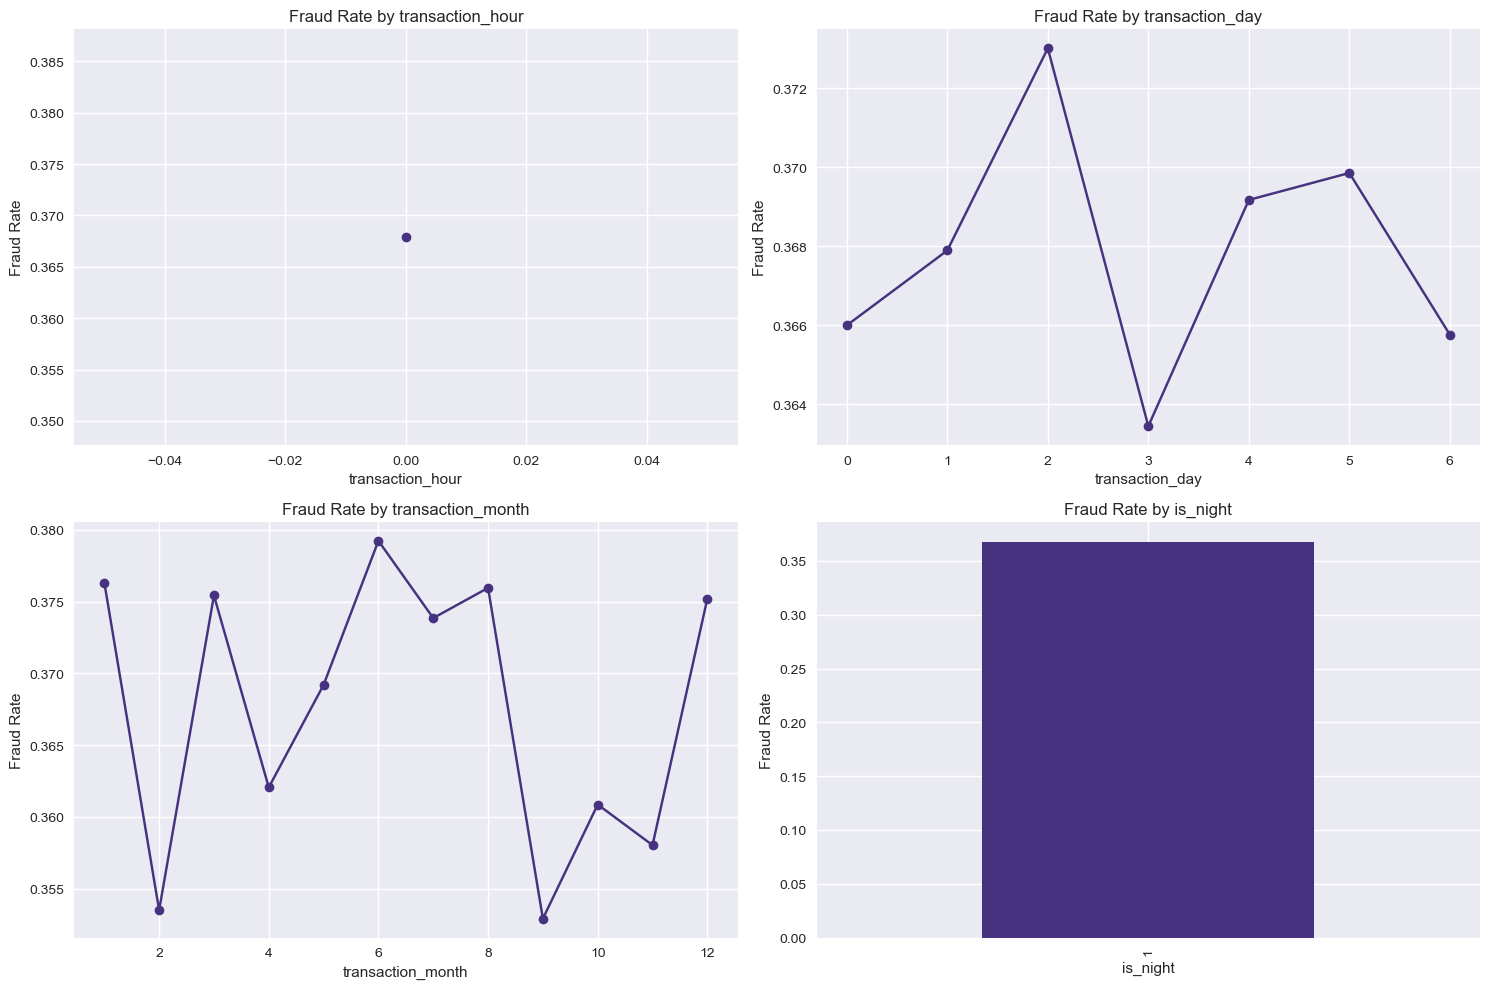

In [61]:
#. TIME-BASED ANALYSIS 
time_vars = ['transaction_hour', 'transaction_day', 'transaction_month', 'is_night']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(time_vars):
    fraud_by_time = data.groupby(col)['is_fraud'].mean()
    
    if col != 'is_night':
        # For continuous time variables
        fraud_by_time.plot(kind='line', ax=axes[i], marker='o', linestyle='-')
    else:
        # For binary variable
        fraud_by_time.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f'Fraud Rate by {col}')
    axes[i].set_ylabel('Fraud Rate')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.savefig(figures_path / 'fraud_rate_time.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_rate_time.pdf', bbox_inches='tight')
plt.show()



### DISTRIBUCIONES DE ALGUNAS VARIABLES NÚMERICAS

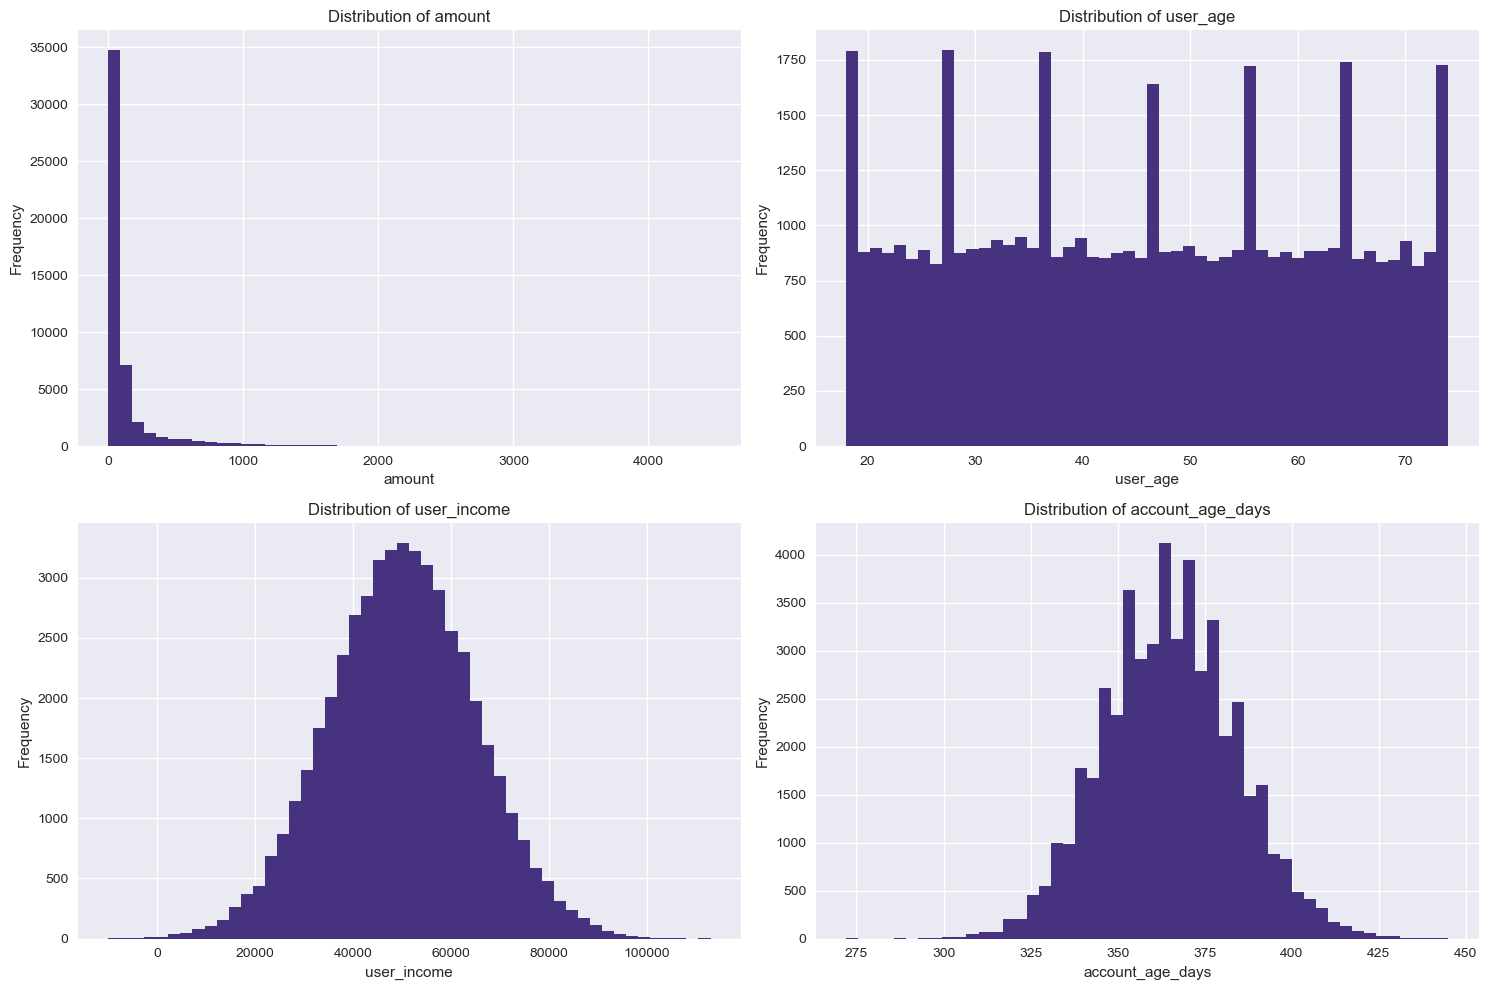

All plots saved to: c:\Users\agust\OneDrive\Documentos\VScode\Fraudes\mlparadetectarfraudes\notebooks\..\reports\figures


In [ ]:
#. DISTRIBUCIONES DE ALGUNAS VARIABLES NÚMERICAS
key_vars = ['amount', 'user_age', 'user_income', 'account_age_days']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(key_vars):
    data[var].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(figures_path / 'key_variables_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'key_variables_distribution.pdf', bbox_inches='tight')
plt.show()

print(f"All plots saved to: {figures_path.absolute()}")

# Outliers

In [60]:
# Detection of outlier values using the interquartile range.
from pathlib import Path

interim_dir = Path('../data/interim')
interim_dir.mkdir(parents=True, exist_ok=True)

stats = data.describe()

for column in data.select_dtypes(include = "number"):
    Q1 = stats[column]['25%']
    Q3 = stats[column]['75%']
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    outliers = data.loc[(data[column] < lower_limit) | (data[column] > upper_limit)]
    
    print(f"Column: {column}")
    print(outliers)
    print("------------------------")
    # Guardar outliers en CSV
    if not outliers.empty:
        outliers.to_csv(interim_dir / f'outliers_{column}.csv', index=False)
        print(f"Outliers for {column} saved to CSV.")

Column: amount
      transaction_datetime    amount  user_age  user_income device_type  \
151             2023-01-13   2872.23        19        85722      mobile   
574             2023-12-05   3265.06        70        91256      mobile   
732             2023-06-26   3437.60        37        81289     desktop   
1044            2023-08-25   4603.59        47        83179      mobile   
1137            2023-05-13   3001.33        22        94440      tablet   
...                    ...       ...       ...          ...         ...   
49993           2023-03-05  10243.77        66        95530      mobile   
49995           2023-06-22   6539.59        38        89025      mobile   
49996           2023-09-14  15464.01        48        76805     desktop   
49997           2023-07-22  15405.87        69        70910      mobile   
49999           2023-04-13   4101.55        67        74511     desktop   

       os_type  browser country city_size  num_products  ...  \
151    Windows     E

# Conclusiones

Probabilidad de fraude por device_type = mobile y os_type = Windows: 1.0
Probabilidad de fraude por is_dead_user: 1.0
Probabilidad de fraude por unusual_device_combo: 1.0

In [68]:
# Analisis de fraude device_type== mobile, os_type== Windows, is_dead_user== 1, unusual_device_combo== 1

print("Analisis de fraude de la peor combinación: device_type== mobile, os_type== Windows, is_dead_user== 1, unusual_device_combo== 1")
print(f"Probabilidad de fraude por peor combinación: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)].shape[0] / data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1)].shape[0])}")
print(f"Dinero perdido por fraude por peor combinación ${data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida  por fraude por peor combinación respecto al total de transacciones: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(6)}%")
print(f"Porcentaje de perdida por fraude por peor combinación respecto al total de transacciones no fraudulentas: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(6)}%")
print(f"Porcentaje de perdida de los fraudes por peor combinación del total de fraudes: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(6)}%")
print(f"Cantidad de fraudes por peor combinación: {data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)].shape[0]:,}")
print("--------------------")

Analisis de fraude de la peor combinación: device_type== mobile, os_type== Windows, is_dead_user== 1, unusual_device_combo== 1
Probabilidad de fraude por peor combinación: 1.0
Dinero perdido por fraude por peor combinación $215.32
Porcentaje de perdida  por fraude por peor combinación respecto al total de transacciones: 0.000214%
Porcentaje de perdida por fraude por peor combinación respecto al total de transacciones no fraudulentas: 0.000366%
Porcentaje de perdida de los fraudes por peor combinación del total de fraudes: 0.000515%
Cantidad de fraudes por peor combinación: 2
--------------------


In [76]:
# Analisis de fraude device_type== mobile, os_type== Windows, is_dead_user== 1, unusual_device_combo== 1

print("Analisis de fraude si es alguno de los casos: {device_type== mobile y os_type== Windows} al mismo tiempo ó is_dead_user== 1 ó unusual_device_combo== 1")
print(f"Probabilidad de fraude: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') | (data['is_dead_user'] == 1) | (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)].shape[0] / data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') | (data['is_dead_user'] == 1) | (data['unusual_device_combo'] == 1)].shape[0])}")
print(f"Dinero perdido por fraude ${data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') | (data['is_dead_user'] == 1) | (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum().round(2):,}")
print(f"Porcentaje de perdida  por fraude respecto al total de transacciones: {(data[(data['device_type'] == 'mobile') | (data['os_type'] == 'Windows') | (data['is_dead_user'] == 1) | (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data['amount'].sum() * 100).round(6)}%")
print(f"Porcentaje de perdida por fraude respecto al total de transacciones no fraudulentas: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') & (data['is_dead_user'] == 1) & (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 0]['amount'].sum() * 100).round(6)}%")
print(f"Porcentaje de perdida de los fraudes del total de fraudes: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') | (data['is_dead_user'] == 1) | (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)]['amount'].sum() / data[data['is_fraud'] == 1]['amount'].sum() * 100).round(6)}%")
print(f"Cantidad de fraudes: {data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') | (data['is_dead_user'] == 1) | (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)].shape[0]:,}")
print(f"Porcentaje de la cantidad de fraudes respecto a la cantidad total de fraudes: {(data[(data['device_type'] == 'mobile') & (data['os_type'] == 'Windows') | (data['is_dead_user'] == 1) | (data['unusual_device_combo'] == 1) & (data['is_fraud'] == 1)].shape[0] / data[data['is_fraud'] == 1].shape[0] * 100)}%")
print("--------------------")

Analisis de fraude si es alguno de los casos: {device_type== mobile y os_type== Windows} al mismo tiempo ó is_dead_user== 1 ó unusual_device_combo== 1


Probabilidad de fraude: 1.0
Dinero perdido por fraude $14,939,706.85
Porcentaje de perdida  por fraude respecto al total de transacciones: 70.671391%
Porcentaje de perdida por fraude respecto al total de transacciones no fraudulentas: 0.000366%
Porcentaje de perdida de los fraudes del total de fraudes: 35.743858%
Cantidad de fraudes: 7,533
Porcentaje de la cantidad de fraudes respecto a la cantidad total de fraudes: 40.95357181689682%
--------------------


In [ ]:
# GUARDAR REPORTE
!jupyter nbconvert --to pdf --output "EDA_FRAUDES.pdf" --output-dir="../reports" "01-EDA.ipynb"

# Dashboard
Todavía no disponibles

## Packages

In [72]:
#%pip install panel ipywidgets --quiet
#%panel extension install--sys precopy --quiet
#%pip install jupyter_bokeh
%pip install panel hvplot holoviews bokeh --quiet
%pip install jupyter_bokeh --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [73]:
import pandas as pd
import numpy as np
import panel as pn
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import plotly.express as px
from datetime import datetime, timedelta
# Activar extensiones necesarias
pn.extension('plotly', 'tabulator')


transaction_datetime', 'amount', 'user_age', 'user_income',
       'device_type', 'os_type', 'browser', 'country', 'city_size',
       'num_products', 'repeat_customer', 'account_age_days',
       'previous_chargebacks', 'is_dead_user', 'transaction_hour',
       'transaction_day', 'transaction_month', 'is_night', 'is_weekend',
       'is_fraud', 'amount_to_income_ratio', 'avg_product_price',
       'high_value_transaction', 'new_customer', 'unusual_device_combo

## Visualization

In [74]:
# Dashboard Estratégico
def dashboard_estrategico():
    # KPIs
    total_amount = data['amount'].sum()
    margen = total_amount * 0.03
    
    # Calcular crecimiento mensual
    monthly_data = data.groupby(data['transaction_datetime'].dt.month)['amount'].sum().reset_index()
    if len(monthly_data) > 1:
        crecimiento = ((monthly_data['amount'].iloc[-1] - monthly_data['amount'].iloc[0]) / 
                       monthly_data['amount'].iloc[0]) * 100
    else:
        crecimiento = 0
    
    # Gráficos
    fig1 = px.line(monthly_data, x='transaction_datetime', y='amount', 
                   title='Ventas Mensuales', labels={'transaction_datetime': 'Mes', 'amount': 'Monto Total'})
    
    fig2 = px.treemap(data, path=['country', 'city_size'], values='amount', 
                      title='Ventas por País y Tamaño de Ciudad')
    
    # Layout
    return pn.Column(
        pn.Row(
            pn.indicators.Number(value=total_amount, name='Ventas Totales', format='${value:,.0f}'),
            pn.indicators.Number(value=margen, name='Margen Bruto', format='${value:,.0f}'),
            pn.indicators.Number(value=crecimiento, name='Crecimiento Anual', format='{value:,.1f}%')
        ),
        pn.Row(fig1, fig2)
    )



In [76]:
# Crear pestañas para el dashboard
strategic_tab = pn.Column(
    pn.pane.Markdown("# Dashboard Estratégico - Análisis de Fraudes"),
    dashboard_estrategico()
)

In [77]:
# Crear dashboard con pestañas
dashboard = pn.Tabs(
    ("Vista Estratégica", strategic_tab)

)

# Servir el dashboard
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'e7056d45-c7d6-46ba-8ed3-9991cda9613d': {'version…

In [75]:
# Dashboard Analítico
country_widget = pn.widgets.Select(options=data['country'].unique().tolist(), name='País:', value='US')
city_size_widget = pn.widgets.Select(options=data['city_size'].unique().tolist(), name='Tamaño de Población:', value='Metro')
fraud_widget = pn.widgets.Select(options=['Todas', 'Solo Fraudes', 'Sin Fraudes'], name='Tipo de Transacción:', value='Todas')

@pn.depends(country_widget.param.value, city_size_widget.param.value, fraud_widget.param.value)
def update_analitico(country, city_size, fraud_type):
    # Filtrar datos
    filtered_data = data[(data['country'] == country) & (data['city_size'] == city_size)]
    
    # Aplicar filtro de fraude
    if fraud_type == 'Solo Fraudes':
        filtered_data = filtered_data[filtered_data['is_fraud'] == 1]
    elif fraud_type == 'Sin Fraudes':
        filtered_data = filtered_data[filtered_data['is_fraud'] == 0]
    
    if filtered_data.empty:
        return pn.Column(pn.pane.Alert("No hay datos para esta selección", alert_type="warning"))
    
    # Crear gráficos
    fig1 = px.line(filtered_data, x='transaction_datetime', y='amount', 
                   title=f'Transacciones de {city_size} en {country}')
    
    fig2 = px.scatter(filtered_data, x='user_id', y='amount', color='is_fraud',
                      title=f'Relación User ID vs Monto', 
                      labels={'user_id': 'ID de Usuario', 'amount': 'Monto', 'is_fraud': 'Es Fraude'})
    
    # Calcular KPIs para el panel
    total_transactions = len(filtered_data)
    fraud_transactions = filtered_data['is_fraud'].sum()
    fraud_rate = (fraud_transactions / total_transactions * 100) if total_transactions > 0 else 0
    
    kpi_row = pn.Row(
        pn.indicators.Number(value=total_transactions, name='Transacciones Totales'),
        pn.indicators.Number(value=fraud_transactions, name='Transacciones Fraudulentas'),
        pn.indicators.Number(value=fraud_rate, name='Tasa de Fraude (%)', format='{value:.2f}%')
    )
    
    return pn.Column(
        kpi_row,
        pn.Row(fig1, fig2),
        pn.pane.DataFrame(filtered_data.nlargest(10, 'amount'), width=1000, height=300)
    )

pn.Column(
    pn.Row(country_widget, city_size_widget),
    update_analitico
).servable()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['transaction_datetime', 'amount', 'user_age', 'user_income', 'device_type', 'os_type', 'browser', 'country', 'city_size', 'num_products', 'repeat_customer', 'account_age_days', 'previous_chargebacks', 'is_dead_user', 'transaction_hour', 'transaction_day', 'transaction_month', 'is_night', 'is_weekend', 'is_fraud', 'amount_to_income_ratio', 'avg_product_price', 'high_value_transaction', 'new_customer', 'unusual_device_combo'] but received: user_id

In [ ]:
analytical_tab = pn.Column(
    pn.pane.Markdown("# Dashboard Analítico - Filtros Detallados"),
    pn.Row(country_widget, city_size_widget, fraud_widget),
    update_analitico
)

In [ ]:
# Reemplaza 'ruta_del_archivo.csv' con la ubicación y nombre de archivo deseados
ruta_del_archivo_csv = 'data_final.csv'

# Exportar el DataFrame a un archivo CSV
data.to_csv(ruta_del_archivo_csv, index=False)

# Imprimir un mensaje de confirmación
print(f"DataFrame exportado exitosamente a '{ruta_del_archivo_csv}' en formato CSV.")


None


In [ ]:
import os

os.makedirs(output_dir, exist_ok=True)
input_dir = path.data_raw_dir()
output_dir = path.data_processed_dir()
(
    vaccination_country_cumulative_df
    .to_csv(
        path_or_buf=output_dir.joinpath("vaccination_country_cumulative.csv"),
        index=False
    )
)